In [75]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [52]:
# Connect to DeepSeek using the OpenAI client python library
load_dotenv(override=True)
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key, base_url="https://openrouter.ai/api/v1")

In [5]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [38]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [9]:
DB = "products_vectorstore"

In [10]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [11]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [12]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [14]:
def vector(item):
    return model.encode([description(item)])

In [15]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [16]:
documents, prices = find_similars(test[1])

In [17]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Four Seasons 78348 New AC Compressor
New Compressor And Clutch Four Seasons 78348 New Nippondenso 10S17F Compressor w/ Clutch Part number 78348 Package Weight 14.55 pounds Package Dimensions 20.574 H x 28.194 L x 18.034 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Weight 6 Pounds, Dimensions 11.3 x 7.2 x 7.8 inches, Country of Origin China, model number 78348, Manufacturer Part 78348, Voltage 120 Volts, Rank Automotive Automotive Replacement Air Conditioning Compressors 1383, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of
Price is $186.99

Potentially related product:
Motorcraft YH-23 Blower Motor Resistor
Motorcraft YH-23 Blower Motor Resistor Package Dimensions 6.82 L x 2.36 H x 4.63 W (inches) Fit type Vehicle Specific Package Weight 1.83 pounds Country 

In [18]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nFour Seasons 78348 New AC Compressor\nNew Compressor And Clutch Four Seasons 78348 New Nippondenso 10S17F Compressor w/ Clutch Part number 78348 Package Weight 14.55 pounds Package Dimensions 20.574 H x 28.194 L x 18.034 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Weight 6 Pounds, Dimensions 11.3 x 7.2 x 7.8 inches, Country of Origin China, model number 78348, Manufacturer Part 78348, Voltage 120 Volts, Rank Automotive Automotive Replacement Air Conditioning Compressors 1383, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of\nPrice is $186.99\n\nPotentially related product:\nMotorcraft YH-23 Blower Motor Resistor\nMotorcra

In [19]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [20]:
get_price("The price for this is $99.99")

99.99

In [39]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek/deepseek-r1-0528:free", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [46]:
deepseek_api_rag(test[1])

0

In [47]:
Tester.test(deepseek_api_rag, test)

1: Guess: $0.00 Truth: $374.41 Error: $374.41 SLE: 35.14 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $0.00 Truth: $225.11 Error: $225.11 SLE: 29.39 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.50 Truth: $61.68 Error: $26.18 SLE: 0.29 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $440.00 Truth: $599.99 Error: $159.99 SLE: 0.10 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $13.99 Truth: $16.99 Error: $3.00 SLE: 0.03 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $10.99 Truth: $31.99 Error: $21.00 SLE: 1.02 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $62.51 Truth: $101.79 Error: $39.28 SLE: 0.23 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $0.00 Truth: $289.00 Error: $289.00 SLE: 32.15 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $299.99 Truth: $635.86 Error: $335.87 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $0.00 Truth: $65.99 Error: $65.99 SLE: 17.68 It

UnboundLocalError: cannot access local variable 'reply' where it is not associated with a value

In [33]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

completion = client.chat.completions.create(
  extra_headers={
    "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
    "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  },
  extra_body={},
  model="deepseek/deepseek-r1-0528:free",
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)
print(completion.choices[0].message.content)

That profound question has echoed through human history, sparking philosophy, religion, science, art, and deep personal reflection. There isn't one universally agreed-upon answer, and the "meaning" often depends on your perspective and beliefs. Here’s a breakdown of common approaches to finding meaning:

1.  **Religious/Spiritual Perspectives:**
    *   **Purpose:** Life's meaning comes from a higher power (God, gods, the Universe). We exist to fulfill a divine plan, achieve union with the divine, progress spiritually, learn lessons for the soul, or serve a greater purpose.
    *   *Examples:* Serving God (Abrahamic faiths), achieving enlightenment/nirvana (Buddhism, Hinduism), living in harmony with the Tao (Taoism).

2.  **Philosophical Perspectives:**
    *   **Existentialism:** **Life has no inherent, predefined meaning.** It's up to each individual to *create* their own meaning and purpose through actions, choices, values, and experiences. Authenticity and responsibility are key (

In [57]:
import google.generativeai as genai
import os

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

model = genai.GenerativeModel("gemini-1.5-flash")  # Or gemini-1.5-pro, gemini-2.5-pro, etc.
response = model.generate_content("Explain how AI works in a few words")

print(response.text)


Learning patterns from data to make predictions.



In [58]:
def gemini_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
    while not done and retries > 0:
        try:
            model = genai.GenerativeModel("gemini-1.5-flash")  # Or gemini-1.5-pro, gemini-2.5-pro, etc.
            response = model.generate_content(messages_for(item, documents, prices))
            reply = response.text
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [59]:
gemini_api_rag(test[1])

AttributeError: 'GenerativeModel' object has no attribute 'encode'

In [74]:
import os
import google.generativeai as genai
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

def vector(item):
    return embedding_model.encode([description(item)])[0]

def gemini_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    reply = None

    while not done and retries > 0:
        try:
            model = genai.GenerativeModel("gemini-2.5-flash")
            # Convert OpenAI-style messages to a single prompt
            prompt = "\n".join([f"{m['role'].capitalize()}: {m['content']}" for m in messages_for(item, documents, prices)]) # make the prompt the gemini way (different from openai)
            response = model.generate_content(prompt)
            reply = response.text
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1

    if reply is None:
        return "ERROR: Gemini failed after retries"

    return get_price(reply)


KeyboardInterrupt: 

In [72]:
gemini_api_rag(test[1])

135.0

1: Guess: $300.99 Truth: $374.41 Error: $73.42 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $155.50 Truth: $225.11 Error: $69.61 SLE: 0.14 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.99 Truth: $61.68 Error: $13.69 SLE: 0.06 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $409.99 Truth: $599.99 Error: $190.00 SLE: 0.14 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $44.99 Truth: $16.99 Error: $28.00 SLE: 0.88 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $39.99 Truth: $31.99 Error: $8.00 SLE: 0.05 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $119.99 Truth: $101.79 Error: $18.20 SLE: 0.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $479.99 Truth: $635.86 Error: $155.87 SLE: 0.08 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $55.50 Truth: $65.99 Error: $10.49 SLE: 0.03 

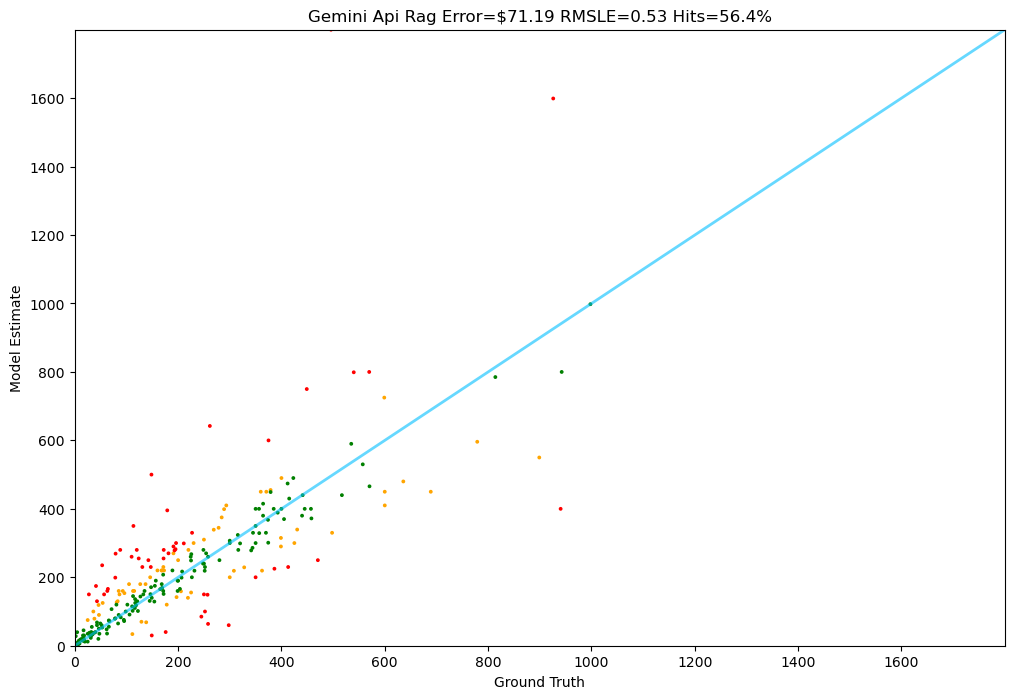

In [73]:
Tester.test(gemini_api_rag, test)